# Elasticidade de preço - Sales:

### Objetivos:
- Identificar insights sobre os produtos relacionados a  giro e faturamento
- Criar modelo de elasticidade de preços para verificar quais produtos são mais propensos ao aumento de ticket
- Mostrar impactos financeiros sobre a decisão de aumento de ticket médio
---
Para esse projeto vou utilizar a seguinte estrutura:

1. Definição do problema (Pode ser encontrada no ReadMe)
2. Coletar dados e gerar uma visão geral
3. Dividir em treinamento e teste
4. EDA - Analise exploratória de dados
5. Feature engineering, limpeza e pré processamento.
6. Treinamento de modelo e feature selection.
7. Produção final do modelo, avaliação e testes.
8. Conclusão e interpretar resultados.
9. Deploy
---
### Estrutura do Dataset:
| Coluna        | Descrição                                                           |
|---------------|---------------------------------------------------------------------|
| Sales Person  | *Nome do vendedor responsável pela transação*                       |
| Country	      | *Região de vendas ou localização da loja onde a transação ocorreu*  |
| Product       | *Nome do produto de chocolate vendido*                              |
| Date          | *A data da transação da venda de chocolate*                         |
| Amount        | *Receita total gerada a partir da venda.*                           |
| Boxes Shipped | *Número de caixas de chocolate enviadas na ordem.*              |



#### Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from elasticidadepreco.outliers import outliersCalc
from elasticidadepreco.elasticidade import elasticidade
from sklearn.preprocessing import StandardScaler
from elasticidadepreco.graphics import categoricalDistri
from   elasticidadepreco.graphics import numericalDistri
import warnings

# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

warnings.filterwarnings('ignore')

#### Entendendo os dados

link dataset:https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales?select=Chocolate+Sales.csv

In [2]:
df = pd.read_csv('../data/raw/Chocolate Sales.csv', encoding='utf-8')

In [3]:
df.head()

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04-Jan-22,"$5,320",180
1,Van Tuxwell,India,85% Dark Bars,01-Aug-22,"$7,896",94
2,Gigi Bohling,India,Peanut Butter Cubes,07-Jul-22,"$4,501",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27-Apr-22,"$12,726",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24-Feb-22,"$13,685",184


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sales Person   1094 non-null   object
 1   Country        1094 non-null   object
 2   Product        1094 non-null   object
 3   Date           1094 non-null   object
 4   Amount         1094 non-null   object
 5   Boxes Shipped  1094 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 51.4+ KB


In [5]:
print(f'{df.shape[0]} linhas  \n{df.shape[1]} colunas')

1094 linhas  
6 colunas


In [6]:
df.isnull().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

In [7]:
df.duplicated().sum()

0

- Vou alterar o nome de colunas para um formato mais amigavel
- E alterar os tipos para facilitar os processos
- E limpar um pouco a variavel de preço e data, para gerar analises mais precisas

In [8]:
df = df.rename(columns={
    'Sales Person': 'sales_person',
    'Country': 'country',
    'Product': 'product',
    'Date': 'date',
    'Amount': 'amount',
    'Boxes Shipped': 'boxes_shipped',
})

In [9]:
df['amount'] = df['amount'].str.replace('[\$,]', '', regex=True).str.strip().astype(int)

In [10]:
df['country'] = df['country'].astype('category')

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

In [12]:
df = elasticidade(df, 'boxes_shipped', 'amount')

- Criei uma função só pra calcular a elasticidade, pois vou trabalhar com essa nova feature como variavel dependente. Fiz essa escolha porque facilita muito o calculo da elasticidade, que é o foco aqui, não gera perigo de vazamento de dados e na implantação do projeto consigo trabalhar com novos dados criando uma etapa anterior a aplicação do modelo, vou mostrar isso na etapa de deploy

#### Divisão de treinamento e testes

- Vou splitar os dados agora para não sofrer com  vazamento de dados nem com overfitting, e para garantir que a avaliação do modelo será com dados mais próximos do cenário real (dado o projeto)

In [13]:
X = df.drop(columns=['elasticity'])
y = df['elasticity'].copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
print(f'X_train shape: {X_train.shape}.')
print(f'x_train shape: {y_train.shape}.')
print(f'X_test shape: {X_test.shape}.')
print(f'y_test shape: {y_test.shape}.')

X_train shape: (875, 8).
x_train shape: (875,).
X_test shape: (219, 8).
y_test shape: (219,).


#### Analise Exploratória de Dados - EDA

- Vou analisar os dados de treino para entender melhor seu comportamento, encontrar insights sobre o negócio. Além de procurar relacionamentos, correlações, tendênciais e demais coisas que possam ajudar na modelagem e na resolução dos objetivos
- Vou separar a analise em univariada e multivariada
- E aplicar visualizações para ter clareza das próximas decisões que vou tomar

In [16]:
train = pd.concat([X_train, y_train], axis=1)
train.head()

,sales_person,country,product,date,amount,boxes_shipped,change_qtd,change_price,elasticity
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685,176,3.631579,1.545573,2.349665
789,Ches Bonnell,New Zealand,Caramel Stuffed Bars,2022-06-30,7588,42,-0.848375,2.763889,-0.306950
1049,Ches Bonnell,India,99% Dark & Pure,2022-02-16,455,96,0.263158,-0.875240,-0.300669
837,Kaine Padly,Australia,50% Dark Bites,2022-08-02,8995,78,-0.748387,1.466411,-0.510353
661,Gunar Cockshoot,Canada,50% Dark Bites,2022-01-04,3024,23,-0.303030,0.213483,-1.419458


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 875 entries, 6 to 860
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sales_person   875 non-null    object        
 1   country        875 non-null    category      
 2   product        875 non-null    object        
 3   date           875 non-null    datetime64[ns]
 4   amount         875 non-null    int32         
 5   boxes_shipped  875 non-null    int64         
 6   change_qtd     874 non-null    float64       
 7   change_price   874 non-null    float64       
 8   elasticity     874 non-null    float64       
dtypes: category(1), datetime64[ns](1), float64(3), int32(1), int64(1), object(2)
memory usage: 59.2+ KB


In [18]:
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude=[np.number]).columns.tolist()  # Inclui date

In [19]:
numeric_features

['amount', 'boxes_shipped', 'change_qtd', 'change_price', 'elasticity']

In [20]:
categorical_features

['sales_person', 'country', 'product', 'date']

In [21]:
categorical_features.pop()

'date'

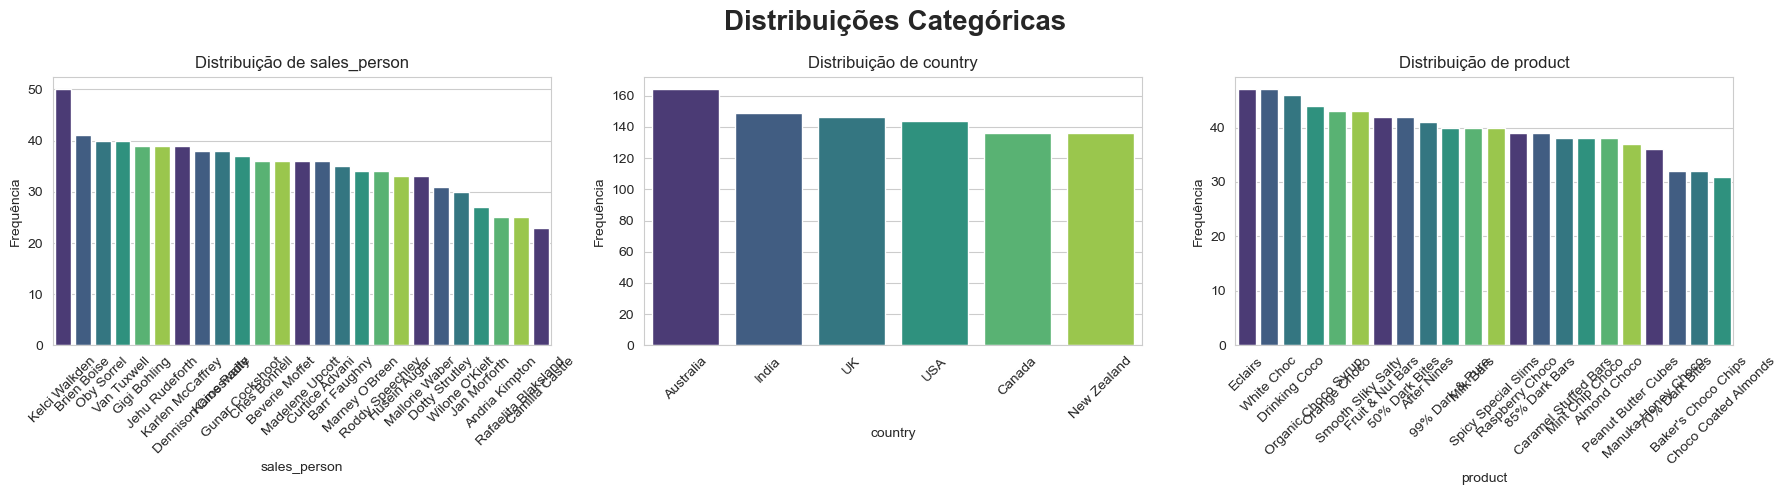

In [43]:
categoricalDistri(train,categorical_features)

In [23]:
print('-' *40)
for col in categorical_features:
    print(f'{col} valores únicos: {train[col].nunique()}')
    print('-' *40)
    print(f'{train[col].value_counts().sort_values(ascending=False)}')
    print('-' *40)

----------------------------------------
sales_person valores únicos: 25
----------------------------------------
sales_person
Kelci Walkden          50
Brien Boise            41
Oby Sorrel             40
Van Tuxwell            40
Gigi Bohling           39
Jehu Rudeforth         39
Karlen McCaffrey       39
Dennison Crosswaite    38
Kaine Padly            38
Gunar Cockshoot        37
Ches Bonnell           36
Beverie Moffet         36
Madelene Upcott        36
Curtice Advani         36
Barr Faughny           35
Marney O'Breen         34
Roddy Speechley        34
Husein Augar           33
Mallorie Waber         33
Dotty Strutley         31
Wilone O'Kielt         30
Jan Morforth           27
Andria Kimpton         25
Rafaelita Blaksland    25
Camilla Castle         23
Name: count, dtype: int64
----------------------------------------
country valores únicos: 6
----------------------------------------
country
Australia      164
India          149
UK             146
USA            144
Canad

Insights:

- Todos os vendedores fizeram mais que 20 vendas, todos os paises realizaram mais que 120 vendas e todos os produtos estiveram em mais que 20 ordens(transações)
- 22 vendedores atuam em 6 paises diferentes com 22 produtos cadastrados
- Em country e em sales_person , vemos que os valores com maior frequencia de vendas estão a uma grande distância do segundo colado
- Em product temos 2 chocolates com a mesma quantidade de vendas, e a distância para os outros valores não é tão significativa enquanto de country e sales_person
- Em country temos apenas 6 valores diferentes e que são não ordinais, ou seja, posso aplicar um OneHot enconding nessa feature
- Tenho uma hipotese de que em Australia e o vendedor Top 1 , estejam com a menor média de amount (preço) e com a maior média em quantidade de caixa vendidas. Levando em consideração o pensamento lógico de que a quantidade de vendas alta poderia indicar produtos com ticket baixo, fazendo-os focar em vender mais e mais de produtos "baratos". Vou amadurecer esse ideia para posteriormente validar a hipotese

- Vamos analisar os dados numericos agora, e posteriormente visualizar algumas relações entre essas features
- Vou aplicar uma normalização nos dados, para não ter problemas com escalonamento durante o plot


In [24]:
scale = StandardScaler()
train_scaled = train.copy()
for col in numeric_features:
    train_scaled[col] = scale.fit_transform(train[[col]])

print(train_scaled[numeric_features].mean())
print(train_scaled[numeric_features].std())

amount           6.496391e-17
boxes_shipped   -8.323501e-17
change_qtd       8.129780e-18
change_price    -1.727578e-17
elasticity       1.016222e-17
dtype: float64
amount           1.000572
boxes_shipped    1.000572
change_qtd       1.000573
change_price     1.000573
elasticity       1.000573
dtype: float64


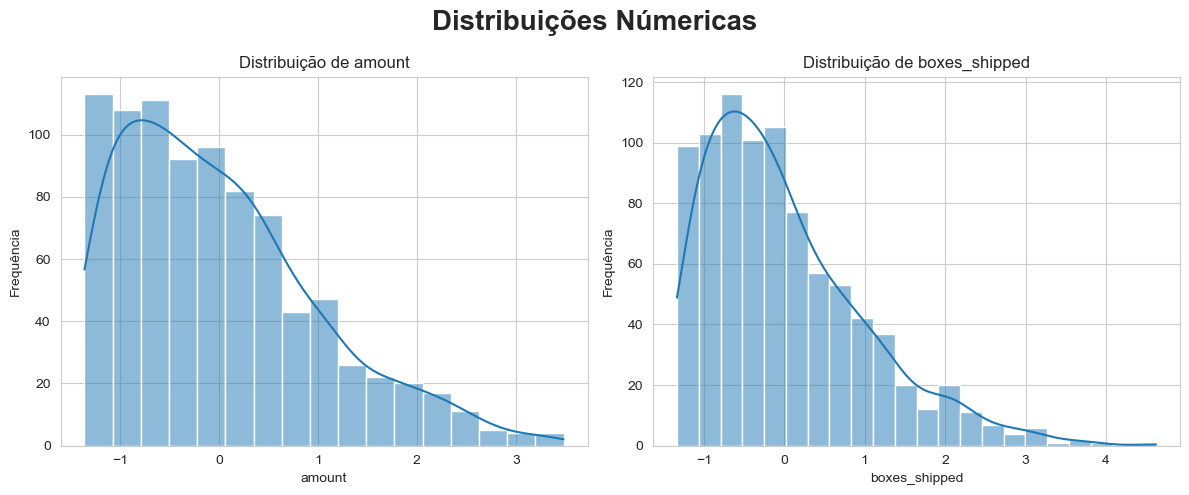

In [25]:
numericalDistri(train_scaled,['amount','boxes_shipped'],2)

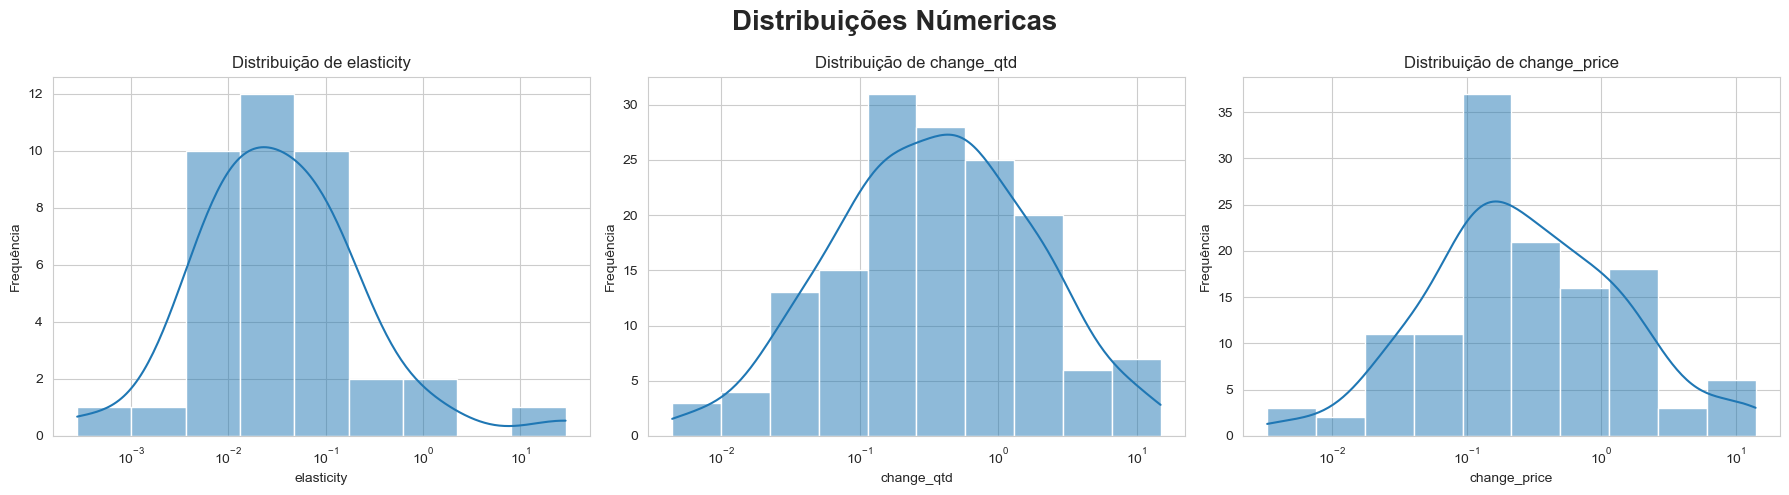

In [26]:
numericalDistri(train_scaled,['elasticity','change_qtd','change_price'],3,logScale=True)

Insights:

- Muitas vendas com pouca boxes_shipped(caixas entregues) e com receita total baixa(amount), significa que a maior frequencia das transações são com baixo faturament por unidade de venda e baixo numero de caixas entregues, indicando uma provavel relação direta entre numero de boxes_shipped com amount (não acredito muito nisso, mas é bom registrar para validar)
- Existem produtos/vendas com uma elasticidade muito baixa, indicando um ou mais produtos muito inelasticos, porem aponta um extremo positivo com alta elasticidade, podendo ser um produto bem flexivel a preço/demanda, mas em geral, a maior frequencia esta indicando inelasticidade. Ou seja, temos poucos produtos que se encaixam na caracteristica de aumento de preço com baixo impacto na demanda
- Vemos uma semelhancia nas curva de amount e de boxes_shipped, indicando talvez uma possível relação entre essas features
- A medida em que o amount vai aumentando, o numero de caixas vendidas/entregues vai diminuindo também, isso reforça minha hipotese que comentei no insghts dos dados categoricos
- Atualização da tese: 'Quando menor é o preço mais caixas são vendidas'
- Talvez seja interessante criar faixas de preço(amount) ja que no grafico podemos observar algumas faixas(colunas) que possuem mínimos semelhantes e uma distancia baixa de max entre elas, uma faixa de preço ajudaria a mostrar de forma mais clara a diferença da frequencia(vendas) em relação ao preço
- Nos dados change_qtd, change_price e elasticty, tive que usar a log scale para conseguir visualizar os dados de forma mais clara p
- Podemos observar que a amplitude deles é alta, com alguns numeros negativos e outros bem mais avançados, isso pode indicar uma variação de preço do mesmo produto em diferentes relacionamento (pais,vendedor,quantidade,etc.) já que, na pratica, mostra que os preços aumentaram, depois diminuiram, tiveram uma variação, porém isso ocorreu poucas vezes, como mostram os graficos
- Vemos que a maior frequencia de elasticidade está indicando estar proximo ou menor que 1 (10^0), indicando uma tendência geral de produtos inelasticos e unitariamente elasticos, que significa que a variação de preço deles impacta a quantidade vendida (demanda), vou confirmar esse ponto analisando mais as correlações das features

### Outliers

In [27]:
outliers = outliersCalc(train_scaled[numeric_features])

In [28]:
outliers.apply(lambda x: x.sum() / x.size * 100)

amount           0.800000
boxes_shipped    1.257143
change_qtd       1.485714
change_price     1.028571
elasticity       0.228571
dtype: float64

- elasticity: Menor proporção de outliers => dados mais consistentes
- amount: Poucos outliers => distribuição relativamente normal
- change_price: Outliers moderados
- boxes_shipped: Alguns valores extremos de quantidade
- change_qtd: Maior proporção de outliers => pode indicar: Mudanças muito drasticas na quantidade, por possivel sazonalidade ou aumento repentino de preço(amount)

Insigths:

- Pouca incidencia de outliers
- Vou optar por não alterar nem excluir os outliers, vou prosseguir com o modelo
- Teoria de que mudanças drasticas na qunatidade vem por sazonalidade de preço/produto


### Multivariada

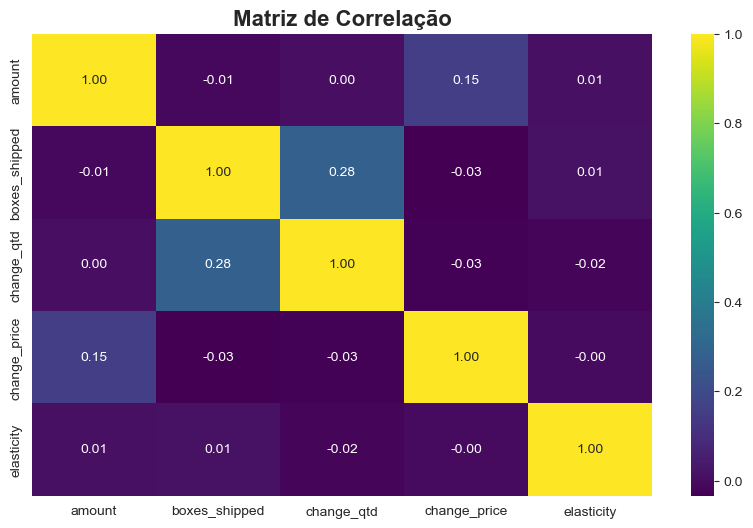

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    train.corr(numeric_only=True),
    annot=True,
    cmap="viridis",
    fmt=".2f"
)
plt.title("Matriz de Correlação", fontsize=16, fontweight="bold")
plt.show()

Insights:

- Existem 2 correlações que chamam a atenção, mesmo sendo corelações fracas a boxes_shipped e change_qtd com 0.28 indica uma correlação fraca entre essas duas features
- em amount e change_price também existe uma correlação fraca de 0.15
- as demais correlações são bem fracas para ter relevância no projeto
- As correlações encontradas em amount e boxes_shipped indicam uma influência direta na variavel dependente elasciticy, pois ela é calculada com base em change_Qtd e change_price

- Analise com feature de date
- relacionaei com boxes_shipped porque amount tem variado muito, e mostra que um mesmo produto tem receita diferente dependendo do pais, vendedor, e outras features, por isso achei que trabalhar com boxes_shipped em analises temporais me traria insights mais confiaveis

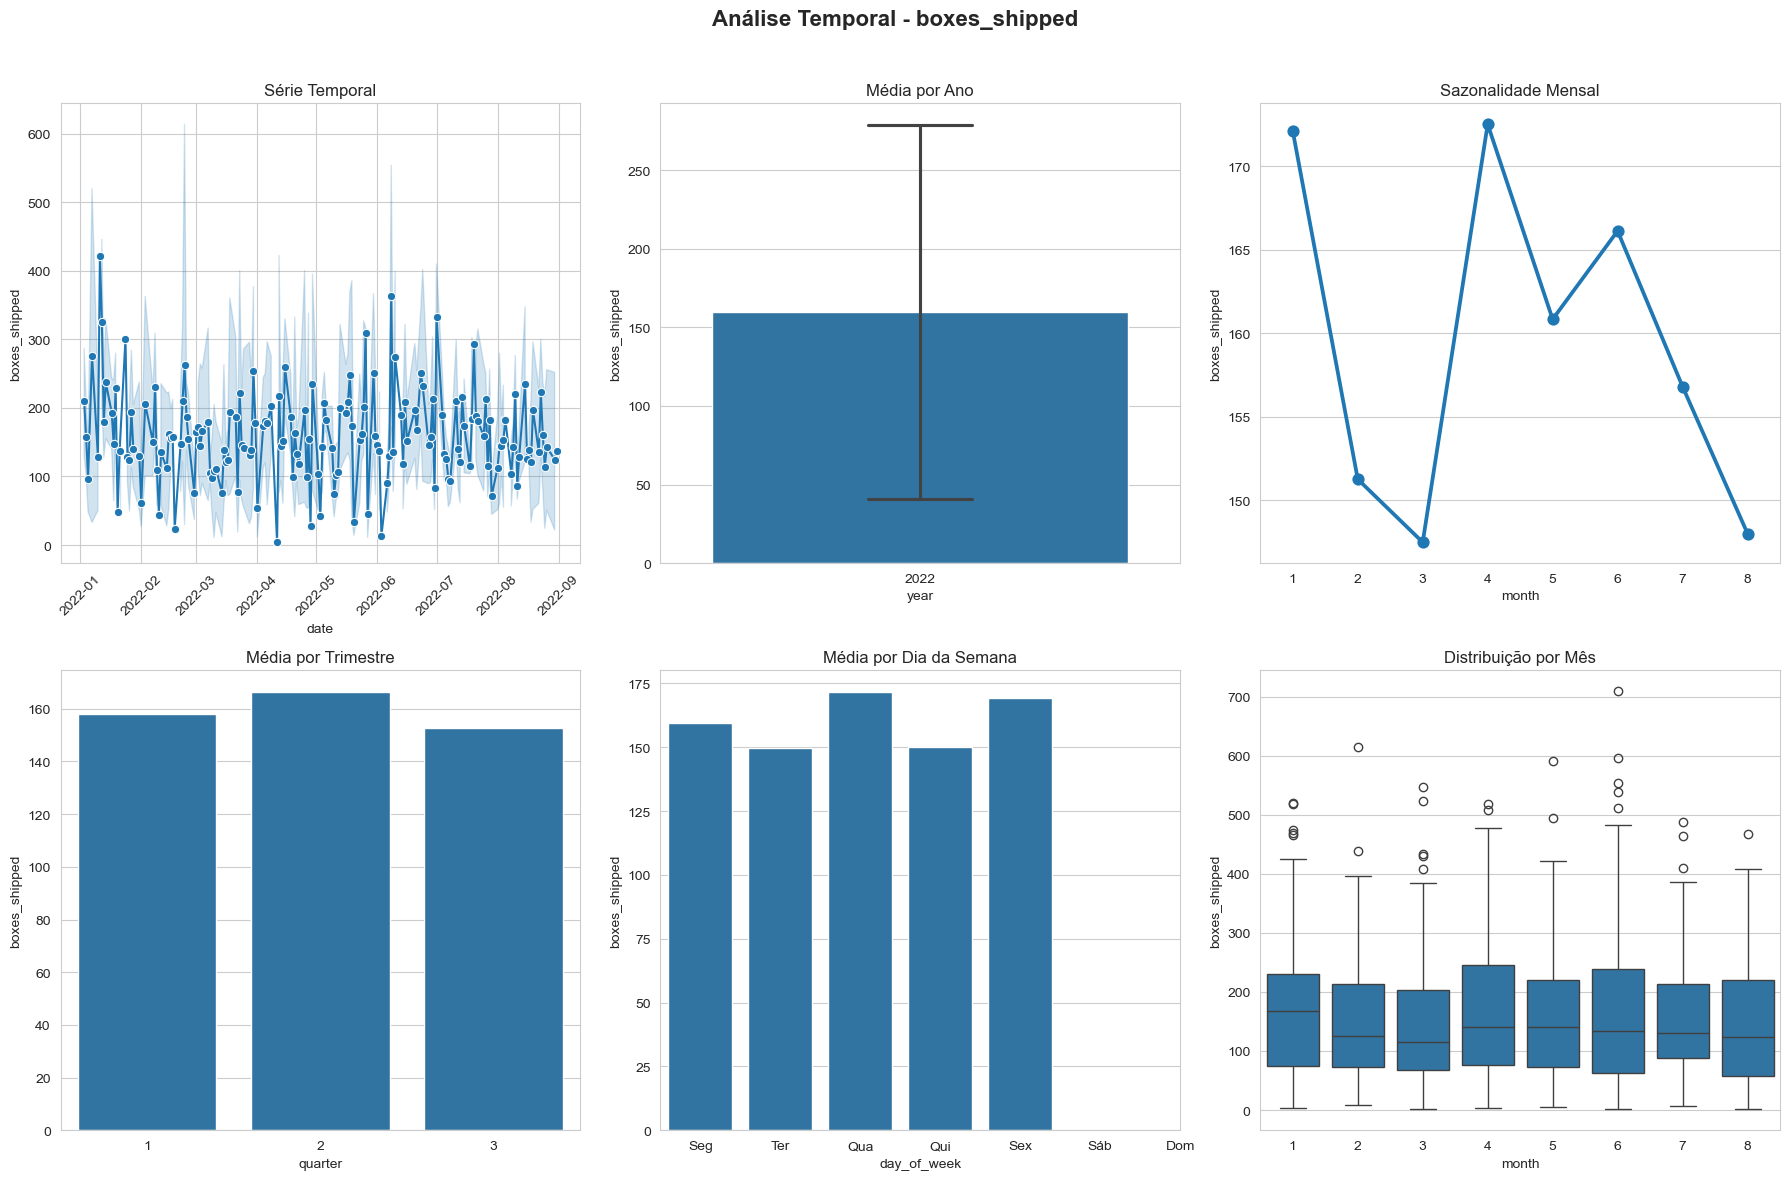

In [73]:
date_col = 'date'
target_col = 'boxes_shipped'

train['year'] = train[date_col].dt.year
train['month'] = train[date_col].dt.month
train['quarter'] = train[date_col].dt.quarter
train['day_of_week'] = train[date_col].dt.dayofweek
train['day_of_month'] = train[date_col].dt.day
train['week_of_year'] = train[date_col].dt.isocalendar().week

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Análise Temporal - {target_col}', fontsize=16, fontweight='bold')

sns.lineplot(data=train, x=date_col, y=target_col, ax=axes[0, 0], marker="o",palette=sns.color_palette("viridis"))
axes[0, 0].set_title('Série Temporal')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=train,
    x="year",
    y=target_col,
    ax=axes[0, 1],
    ci="sd",
    capsize=0.2
)
axes[0, 1].set_title('Média por Ano')
sns.pointplot(
    data=train,
    x="month",
    y=target_col,
    ax=axes[0, 2],
    ci=None
)
axes[0, 2].set_title('Sazonalidade Mensal')

sns.barplot(
    data=train,
    x="quarter",
    y=target_col,
    ax=axes[1, 0],
    ci=None
)
axes[1, 0].set_title('Média por Trimestre')

days = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
sns.barplot(
    data=train,
    x="day_of_week",
    y=target_col,
    ax=axes[1, 1],
    ci=None
)
axes[1, 1].set_title('Média por Dia da Semana')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(days)

sns.boxplot(
    data=train,
    x="month",
    y=target_col,
    ax=axes[1, 2]
)
axes[1, 2].set_title('Distribuição por Mês')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Insights:
- aumento de preço no produto durante a sazonalidade/mes com maior frequencia de vendas
- Durante 2022, temos uma concentração de caixas entregues de 100 a 300 caixas, com alguns picos de queda e de aumento de caixas
- A media do ano é bem constante, em 150 caixas
- Quando analisamos a sazonalidade por mÊs, podemos ver dois picos positivos, no inicio do ano e no mês 4, indicando boas epocas de vendas. Porém temos uma queda vertiginosa no mês 3, e outra queda mais progressiva a partir do mês 5 até o mês 8, indicando redução na quantidade de caixas entregues mas não no faturamento diretamente, pois se analisarmos com o grafico de boxplot, vemos que é nesse mesmo periodo onde temos maior incidencia de outliers em caixas entregues
- ao analisar por trimestre, esses insights são confirmados, por uma queda no ultimo trimestre , queda de caixas entregues
- é bom enfatizar que um numero baixo de caixas entregues, não necessariamente é um numero baixo de faturamento/receita

In [66]:
train['amount_faixa'] = pd.qcut(train['amount'], q=5, labels=False)
train['amount_faixa_label'] = pd.qcut(
    train['amount'],
    q=5,
    labels=['Muito baixo', 'Baixo', 'Médio', 'Alto', 'Muito alto']
)

In [70]:
train[['amount_faixa_label','amount_faixa','amount']].head(10)

,amount_faixa_label,amount_faixa,amount
6,Muito alto,4,13685
789,Alto,3,7588
1049,Muito baixo,0,455
837,Muito alto,4,8995
661,Baixo,1,3024
332,Baixo,1,2912
528,Alto,3,6769
956,Alto,3,7609
215,Alto,3,6538
970,Muito alto,4,10794


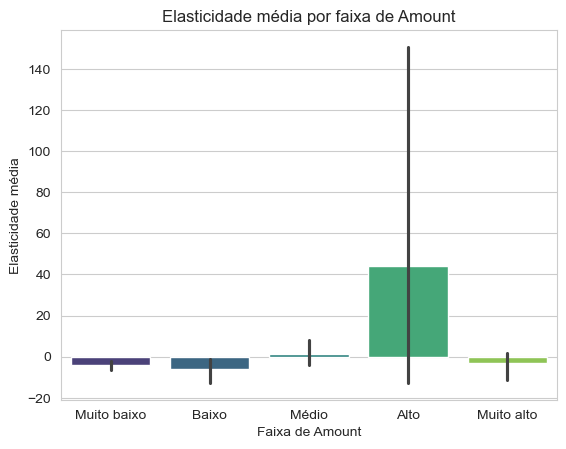

In [71]:
sns.barplot(
    data=train,
    x="amount_faixa_label",
    y="elasticity",
    palette="viridis"
)
plt.title("Elasticidade média por faixa de Amount")
plt.xlabel("Faixa de Amount")
plt.ylabel("Elasticidade média")
plt.show()

Insights:
- Gera uma teoria de que os produtos que estão na faixa de receita alta, são produtos com maior elasticidade, ou podem ser produtos com maior variação de preço ao longo do dataset, mas todavia o grafico esta msotrando que são os com maior elasticidade de preço/demanda
- Pode ser que os produtos com maior elasticidade sejam os produtos que já possuem uma alta amount (receita) e que estjam com maiores registros de vendas a aprtir do mês 5

#### Validando teorias

Teorias Levantadas:
- h1: Quando menor é a receita mais caixas são entregues, menor preço maior quantidade
- h2: Oscilações extremas na quantidade vendida, indicadas pelos outliers em change_qtd, provavelmente refletem efeitos sazonais ou flutuações repentinas no preço do produto
- h3: Produtos com alta receita (amount elevado) apresentam maior elasticidade preço-demanda e tendem a registrar aumento nas vendas a partir do mês 5, indicando maior sensibilidade às variações de preço ao longo do tempo

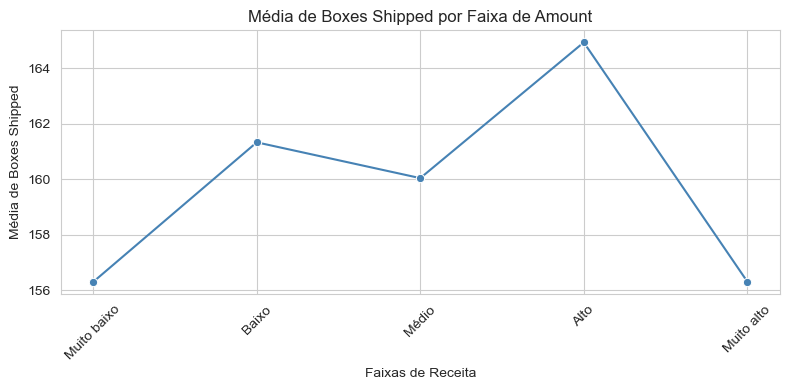

In [99]:
#h1: Quando menor é a receita mais caixas são entregues, menor preço maior quantidade

mediaBoxes = train.groupby('amount_faixa_label')['boxes_shipped'].mean().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(
    data=mediaBoxes,
    x='amount_faixa_label',
    y='boxes_shipped',
    marker='o',
    color='steelblue'
)
plt.xticks(rotation=45)
plt.xlabel('Faixas de Receita')
plt.ylabel('Média de Boxes Shipped')
plt.title('Média de Boxes Shipped por Faixa de Amount')
plt.tight_layout()
plt.show()

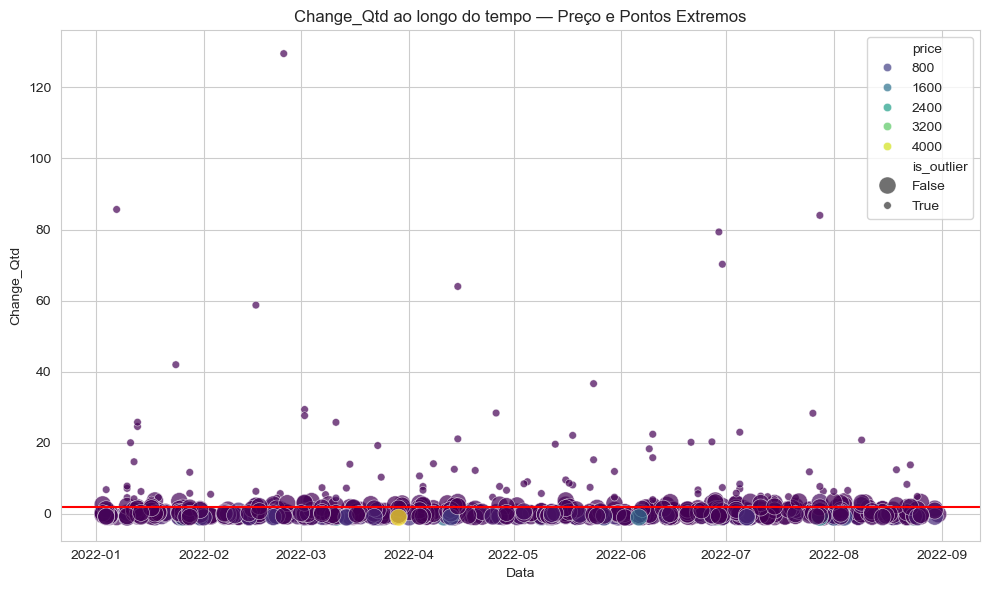

In [103]:
train['price'] = train['amount'] / train['boxes_shipped']

Q1 = train['change_qtd'].quantile(0.25)
Q3 = train['change_qtd'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
train['is_outlier'] = (train['change_qtd'] < lower) | (train['change_qtd'] > upper)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=train,
    x='date',
    y='change_qtd',
    hue='price',
    size='is_outlier',
    sizes=(30, 150),
    palette='viridis',
    alpha=0.7
)

plt.axhline(train['change_qtd'].mean(), color='red', label='Média Change_Qtd')
plt.title('Change_Qtd ao longo do tempo — Preço e Pontos Extremos')
plt.xlabel('Data')
plt.ylabel('Change_Qtd')
plt.tight_layout()
plt.show()


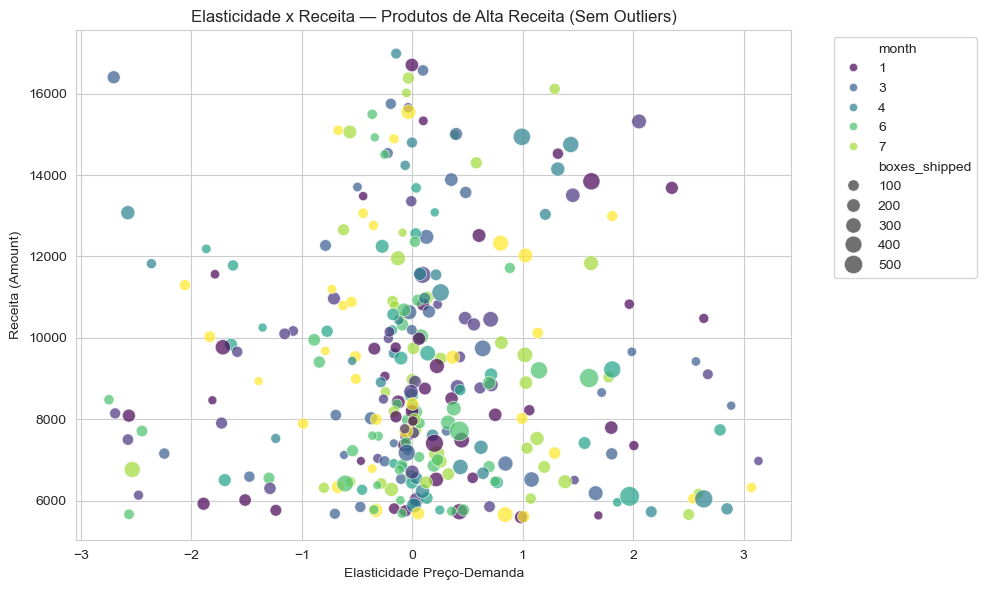

In [104]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

mean_amount = train['amount'].mean()
df_high_amount = train[train['amount'] > mean_amount].copy()

df_high_amount = remove_outliers_iqr(df_high_amount, 'amount')
df_high_amount = remove_outliers_iqr(df_high_amount, 'elasticity')

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_high_amount,
    x='elasticity',
    y='amount',
    hue='month',
    size='boxes_shipped',
    sizes=(40, 200),
    palette='viridis',
    alpha=0.7
)

plt.title('Elasticidade x Receita — Produtos de Alta Receita (Sem Outliers)')
plt.xlabel('Elasticidade Preço-Demanda')
plt.ylabel('Receita (Amount)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Resumo Teorias:

- h1: teoria invalida, não necessariamente quando menor amount maior boxes_shipped
- h2: teoria invalida, outliers de change_qtd estão espalhados ao longo do ano de 2022, não indicando um periodo relevante com maior concentração
- h3: Vemos sim uma quantidade maior de incidencias quando o amount é alto e a elasticidade também, porém nada que confirme de forma concreta a teoria, então é invalida

#### Produtos e Elasticidade

In [113]:
# produtosElast = train.groupby('product')['elasticity'].mean()
# produtos_positivos = produtosElast[produtosElast > 0].sort_values(ascending=False)
# print(produtos_positivos)
#
#


#### EDA -Conclusão

Encerrando a EDA com as seguintes conclusões:

- O preço de um produto varia de acordo com país, vendedor e data
- A maior parte dos produtos possui uma inelasticidade preço-demanda, dificuldade de aumentar o ticket sem impactar a demanda
- Existe uma sazonalidade na quantidade de caixas entregues, com destaque para o mes 1 e mes 3-4
- Temos apenas 5 produtos com elasticidade positiva, com destaque para o Mint Chip Choco, com maior elasticidade.